**Changes to original notebook:**
1. using "benign_objects" to denote objects that should not indicate the
presence of cancer in a patch.
  i. represented graphically with blue circles.

2. using "cancerous_objects" to denote objects that should indicate the presence
of cancer in a patch.
  ii. represented graphically with red circles.

3. changed the max and min diameter and # of objects to more closely matches the
TMA dataset.

4. altered code to accomodate 3D synthetic images (RGB).

5. added visualization scripts from "visualize densenet" file

In [1]:
import random
import tables
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from snippets import print_bag

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 5200739048394920828


In [2]:
dataname="MIL_32x32_100pos"

patch_size= 32 #size of the tiles to put into DB
data_size=np.array([10000, 1000])

num_slides = np.floor(data_size / 244).astype(int)	# the expected ratio of slides to patches is 1:244. (4000^2 / 256^2) So the number of slides should be num_patches/244
train_slide_ids = np.arange(num_slides[0])
val_slide_ids = np.arange(num_slides[1])

classes=[0,1] #what classes we expect to have in the data.
percent_pos_per_slide=1.0

max_benign_objects= 3
max_cancerous_objects=1
diameter_min=5
diameter_max=10

phases=["train","val"]

In [3]:
%cd data

[Errno 2] No such file or directory: 'data'
/home/jackson/DP/MIL_proj1


In [4]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]

In [5]:
%matplotlib inline
storage={} #holder for future pytables

block_shape=np.array((patch_size,patch_size, 3)) #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase,nimgs in zip(phases,data_size): #now for each of the phases, we'll loop through the files
	print(phase)
	
	totals=np.zeros(2) # we can to keep counts of all the classes in for in particular training, since we 

	hdf5_file = tables.open_file(f"./{dataname}_{phase}.pytable", mode='w') #open the respective pytable


	storage["imgs"]= hdf5_file.create_earray(hdf5_file.root, "imgs", img_dtype,  
											shape=np.append([0],block_shape), 
											chunkshape=np.append([1],block_shape),
											filters=filters)
	storage["labels"]= hdf5_file.create_earray(hdf5_file.root, "labels", img_dtype,  
											shape=[0], 
											chunkshape=[1],
											filters=filters)
	storage["slide_ids"]= hdf5_file.create_earray(hdf5_file.root, "slide_ids", img_dtype,
											shape=[0],
											chunkshape=[1],
											filters=filters)

	
	for filei in range(nimgs): #now for each of the files
		print(filei)
		img=np.zeros((patch_size,patch_size))
		img = Image.fromarray(img, mode="RGB")
		draw = ImageDraw.Draw(img)
		
		#draw benign objects on the image.
		for i in range(np.random.randint(1,high=max_benign_objects)):
			d=np.random.randint(diameter_min,diameter_max)
			squeeze_constant = np.random.randint(-d/2, d/2)
			ul=np.random.randint(diameter_min,patch_size-diameter_max,2)
			point2=ul + d
			point2[0] = point2[0] + squeeze_constant
			
			# 3 varieties of benign objects
			variety = np.random.randint(0,3)
			if variety == 0:  # draw blue circle
				draw.ellipse(list(np.append(ul,ul+d)),fill=(0,0,255))
			elif variety == 1:  # draw blue ovals
				draw.ellipse(list(np.append(ul,point2)),fill=(0,0,255))
			elif variety == 2:  # draw red circle
				draw.ellipse(list(np.append(ul,ul+d)),fill=(255,0,0))
	
		slide_id = None
		label = None

		#fairly assign a slide-level id to each patch according to its bag
		if phase == 'train':
			slide_id = train_slide_ids[np.random.randint(0, num_slides[0])]
			if slide_id < num_slides[0]/2:
				label = 0
			else:
				label = 1
		elif phase == 'val':
			slide_id = val_slide_ids[np.random.randint(0,num_slides[1])]
			if slide_id < num_slides[1]/2:
				label = 0
			else:
				label = 1
		
		
		if label:
			if np.random.random() <= percent_pos_per_slide:		# controls the percentage of cancerous patches per slide
				for i in range(np.random.randint(1,high=max_cancerous_objects+1)):
					d=np.random.randint(diameter_min,diameter_max)
					squeeze_constant = np.random.randint(-d/2,d/2)
					ul=np.random.randint(diameter_min,patch_size-diameter_max,2)
					point2=ul + d
					point2[0] = point2[0] + squeeze_constant
					draw.ellipse(list(np.append(ul,point2)),fill=(255,0,0))#red ellipse represents benign
				totals[1]+=1
		else:
			totals[0]+=1
			#add cancerous object to total
		
		del draw

		storage["imgs"].append(np.array(img)[None,::])
		storage["labels"].append([np.uint8(label)])
		storage["slide_ids"].append([np.uint8(slide_id)])
		
	#lastly, we should store the number of pixels
	npixels=hdf5_file.create_carray(hdf5_file.root, 'classsizes', tables.Atom.from_dtype(totals.dtype), totals.shape)
	npixels[:]=totals
	hdf5_file.close()
	
print("done")

train
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


/tmp/ipykernel_2675/3353441180.py:88: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Image'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  storage["imgs"].append(np.array(img)[None,::])


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
print(totals)

[484.  92.]


Visualization

tensor(1, dtype=torch.uint8)
tensor(21, dtype=torch.uint8)


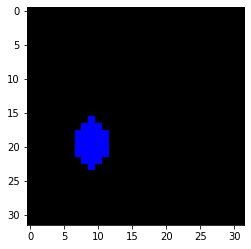

In [ ]:
phase="train"
db=tables.open_file(f"./{dataname}_{phase}.pytable")
imgid=4998
img = db.root.imgs[imgid,::]
#label = torch.tensor(db.root.labels[imgid])
label = torch.tensor(np.array(db.root.labels[imgid]))
slide_id = torch.tensor(np.array(db.root.slide_ids[imgid]))
#img = img[:,:,None].repeat(3,axis=2) #convert to 3 channel
plt.imshow(img)
print(label)
print(slide_id)

In [ ]:
phase="train"
db=tables.open_file(f"./{dataname}_{phase}.pytable")

classbalance = [0,0]
for imgid in range(0, data_size[0]):
    label = torch.tensor(np.array(db.root.labels[imgid])).item()
    if label:
        classbalance[0] = classbalance[0] + 1
    else:
        classbalance[1] = classbalance[1] + 1
print(classbalance)

[5027, 4973]


c:\Users\Ollie\OneDrive\Desktop\PytorchDP\MIL_proj1\snippets.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, cols, figsize=figsize)


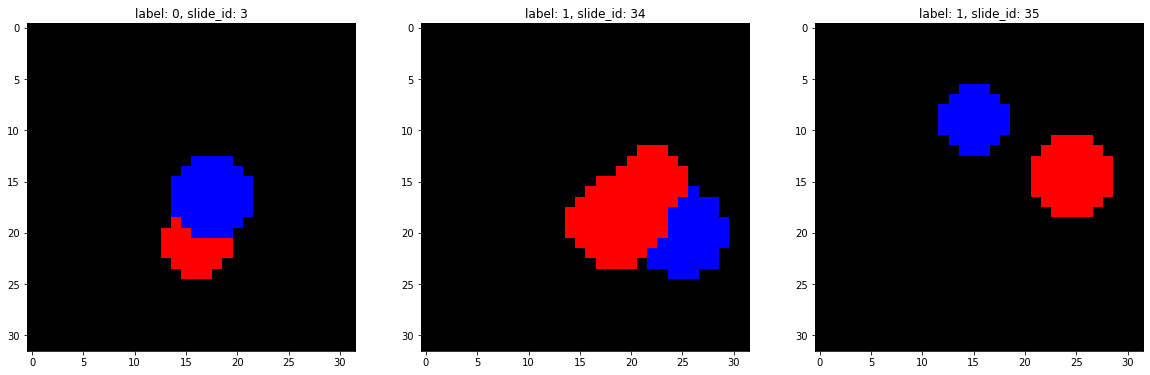

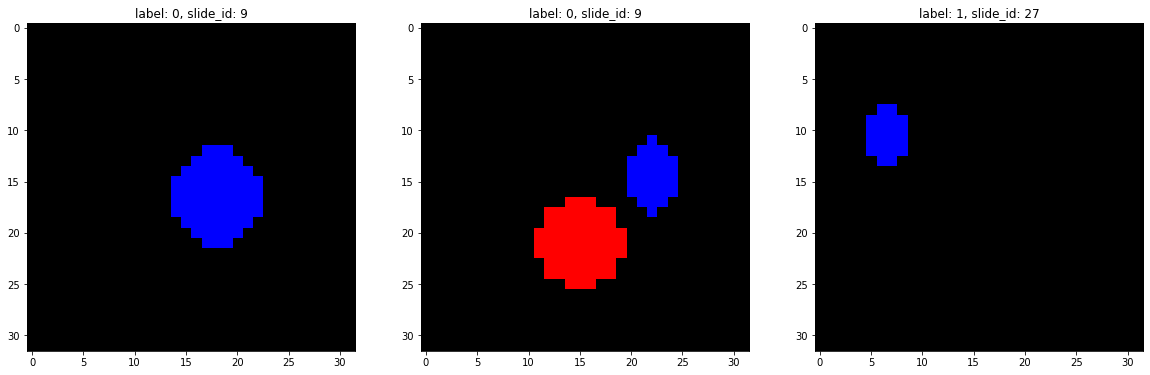

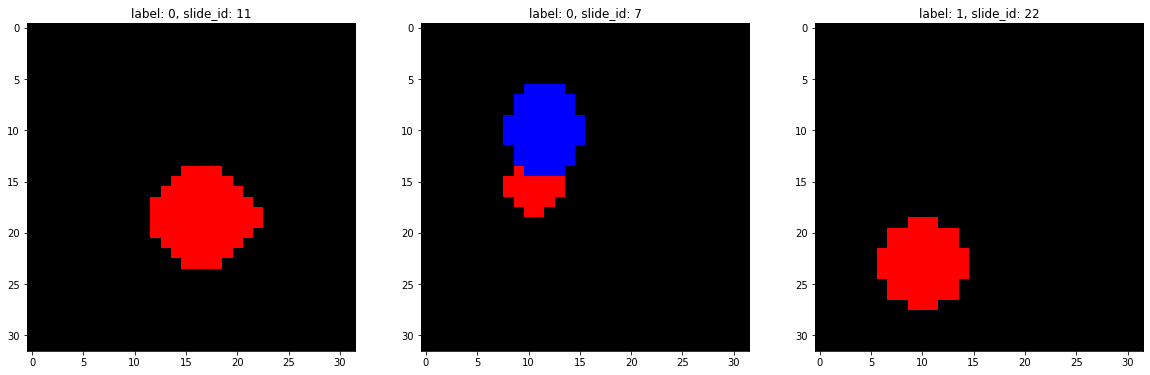

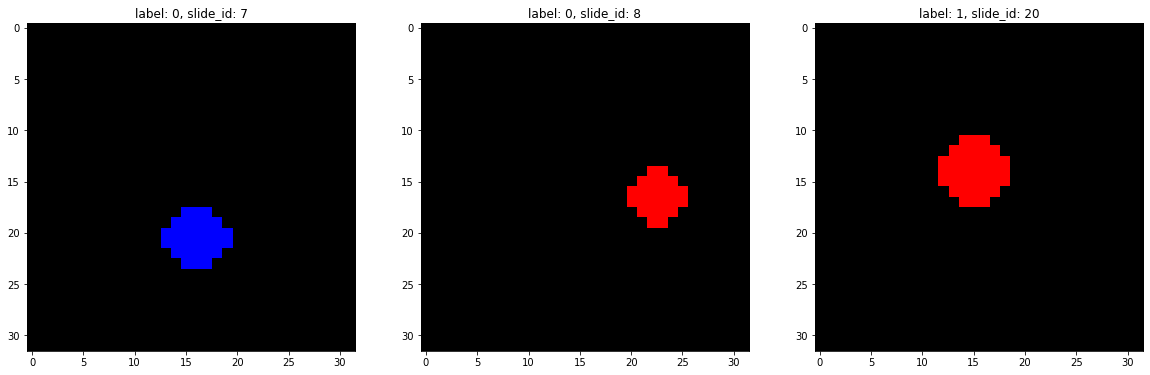

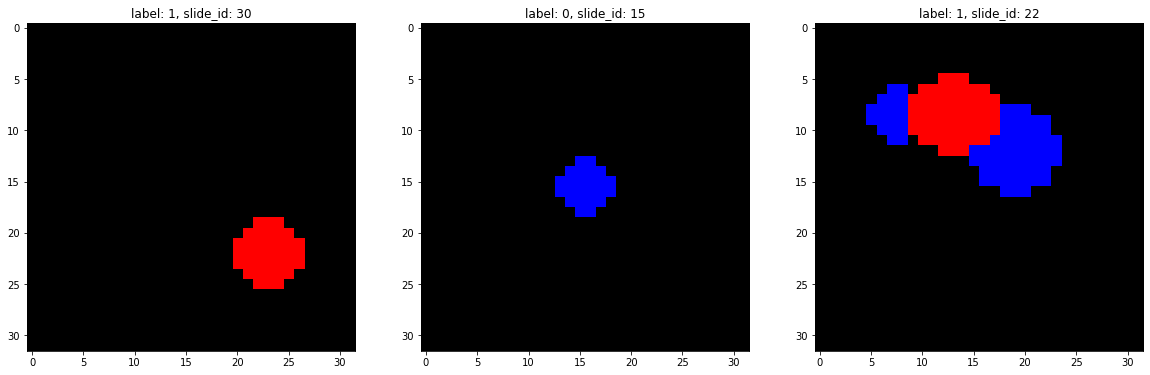

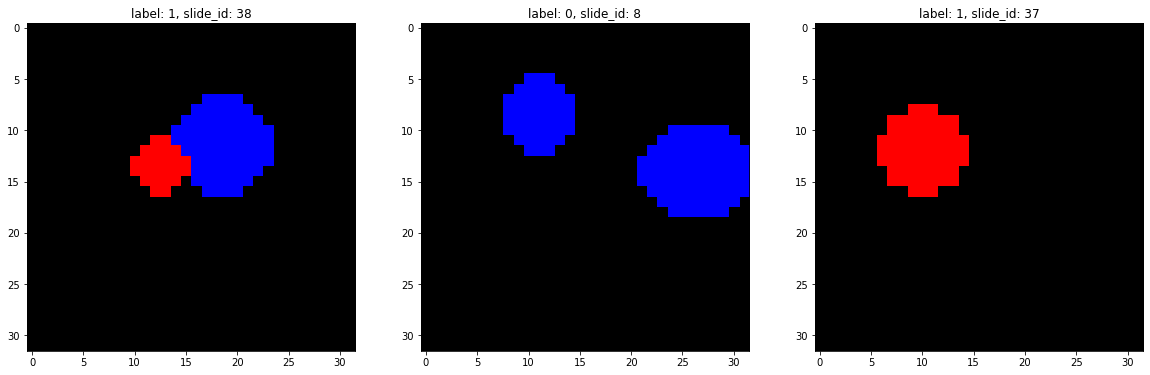

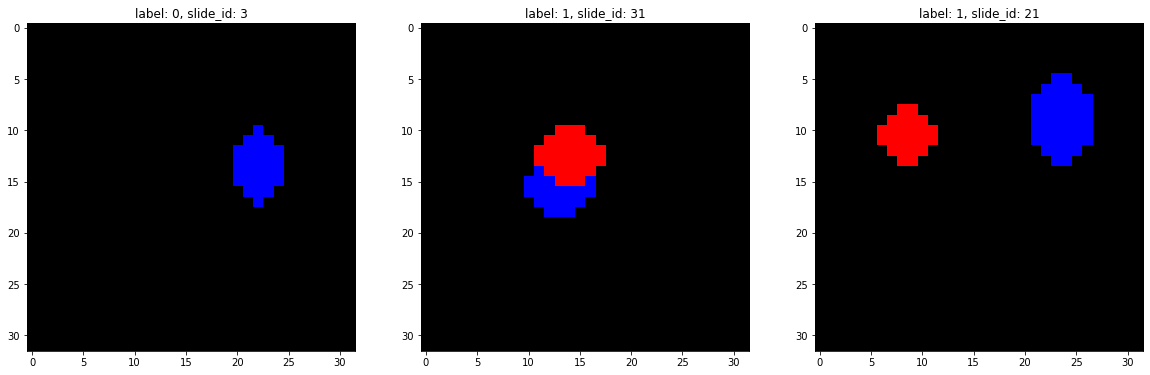

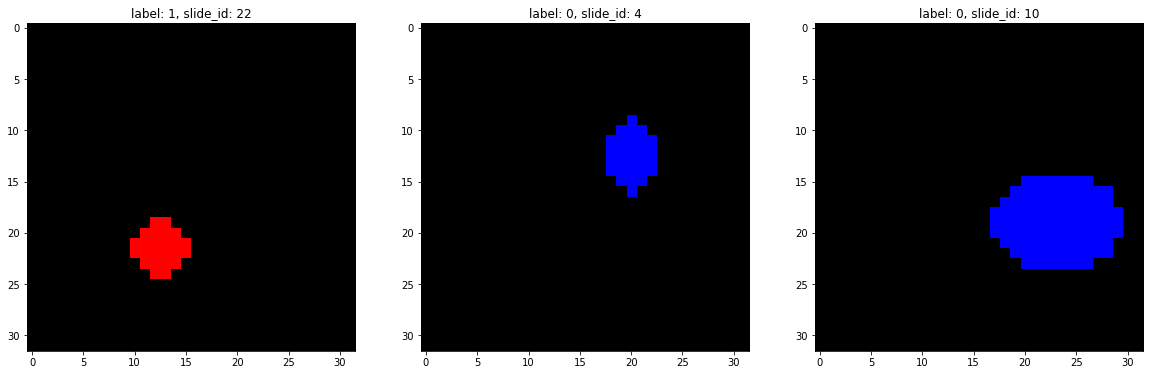

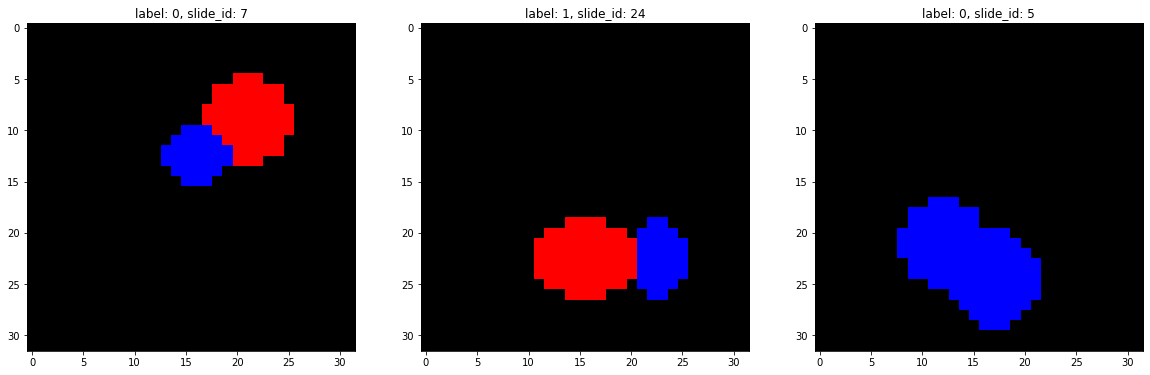

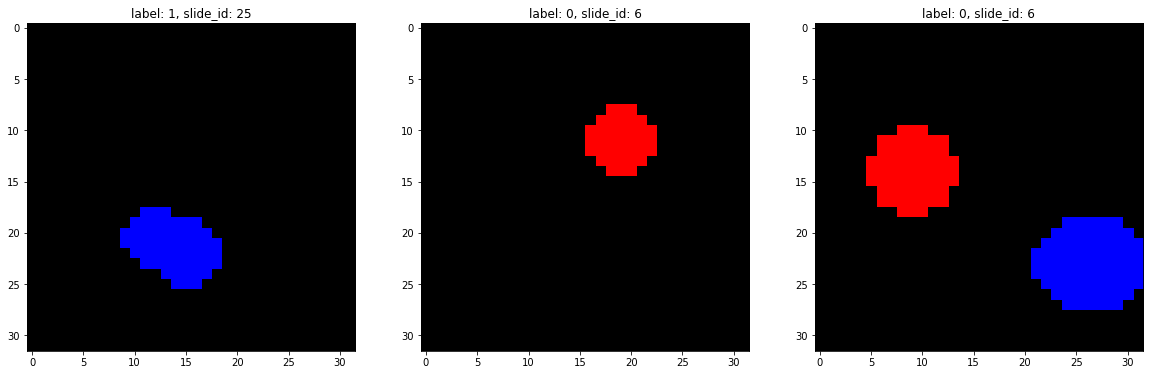

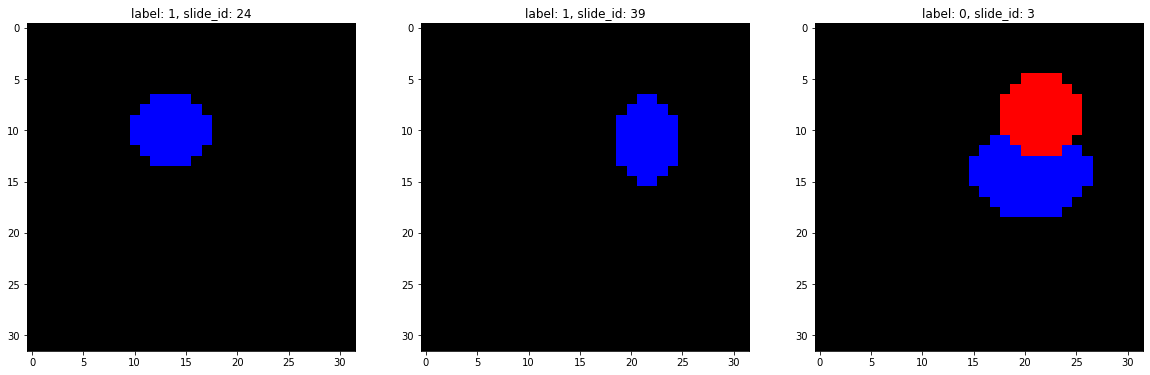

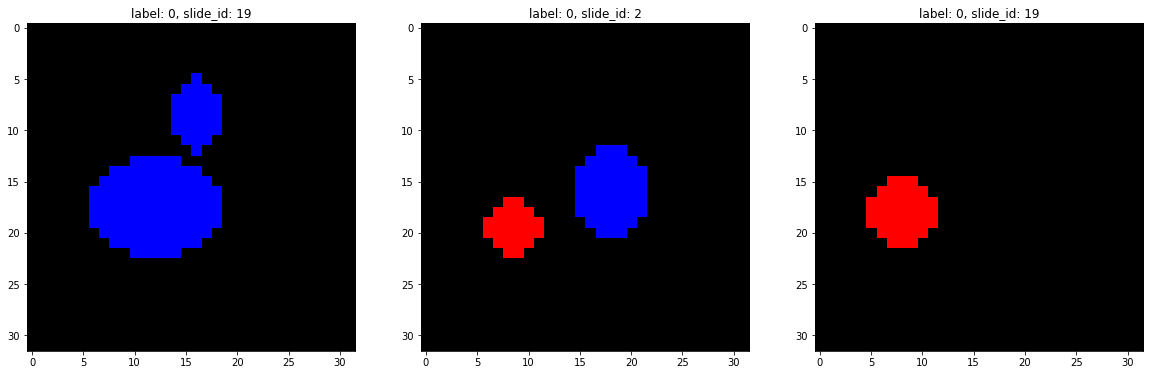

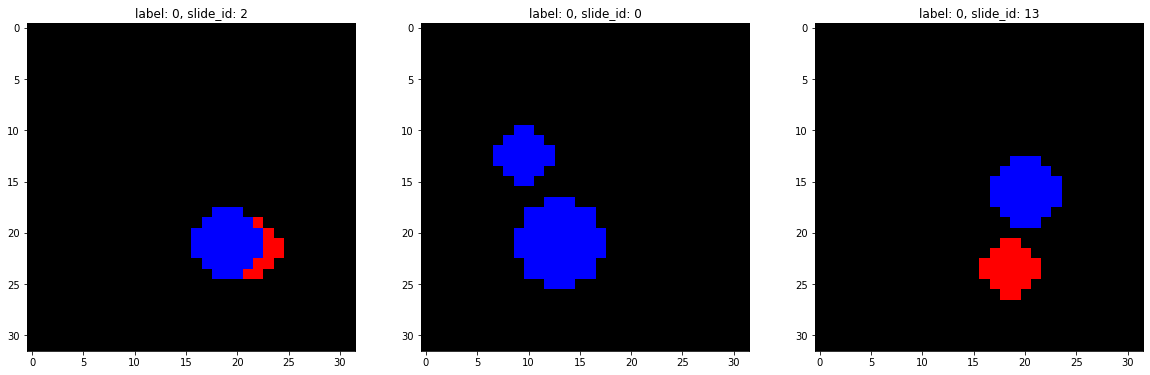

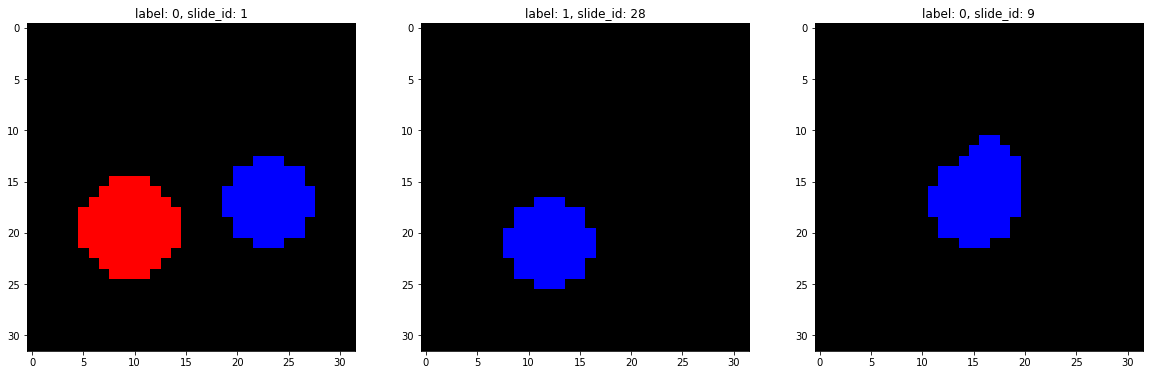

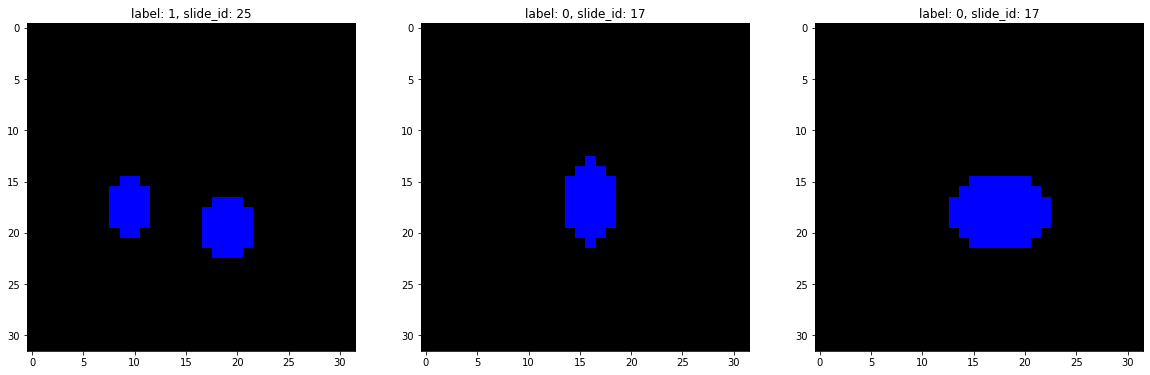

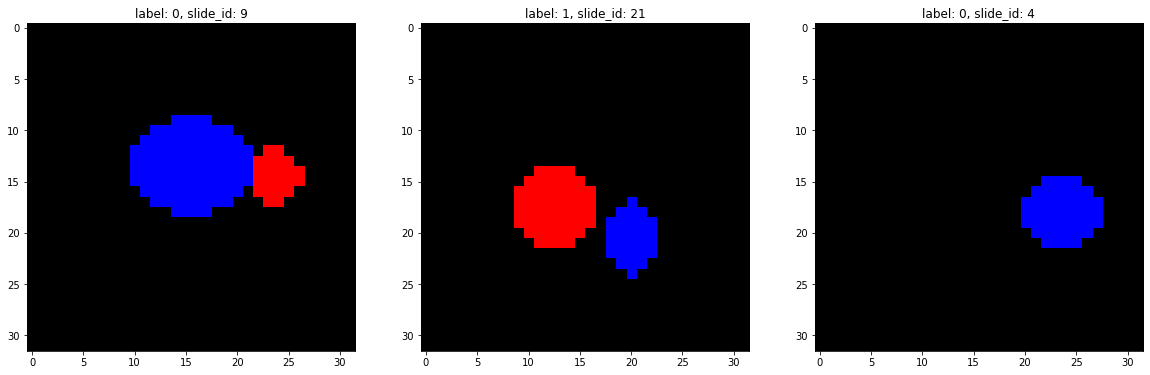

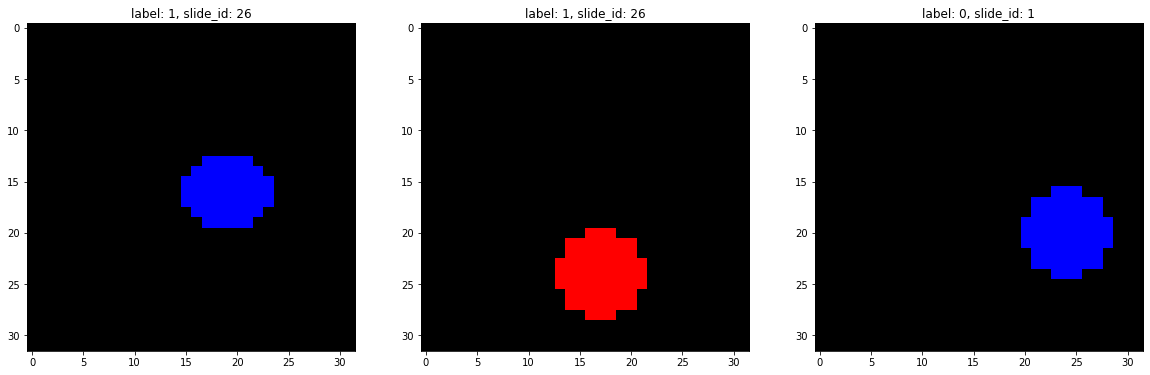

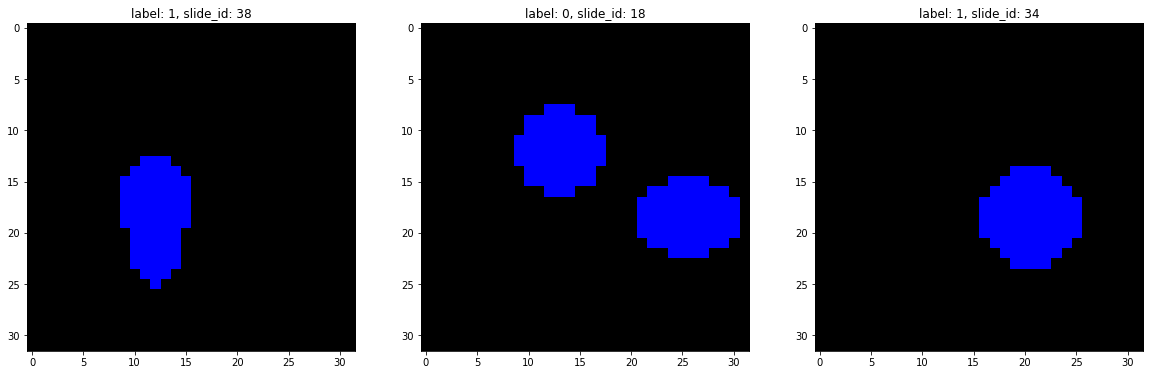

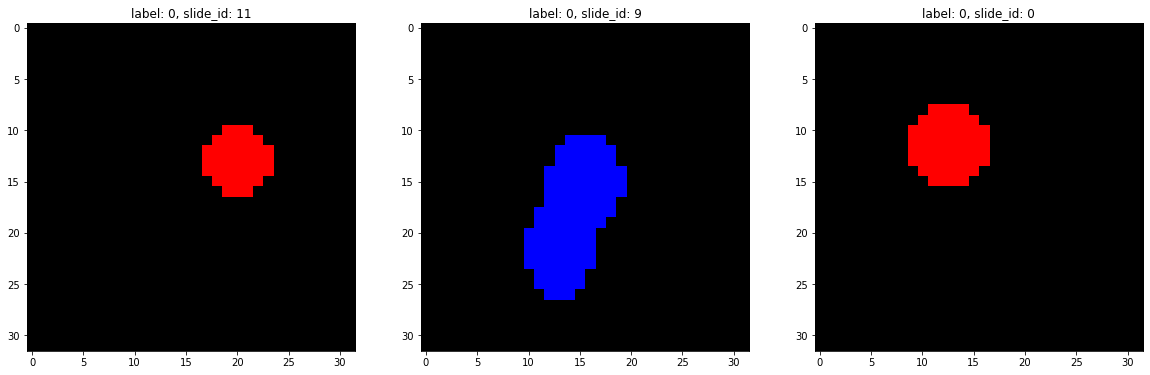

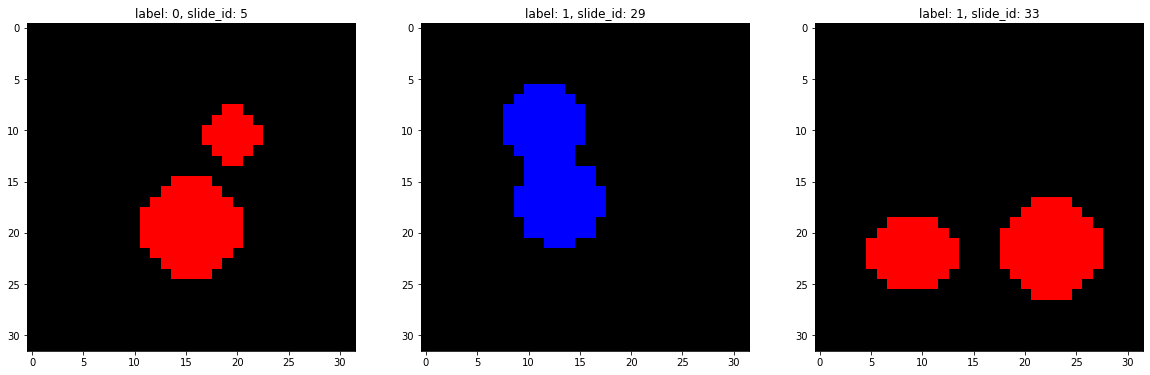

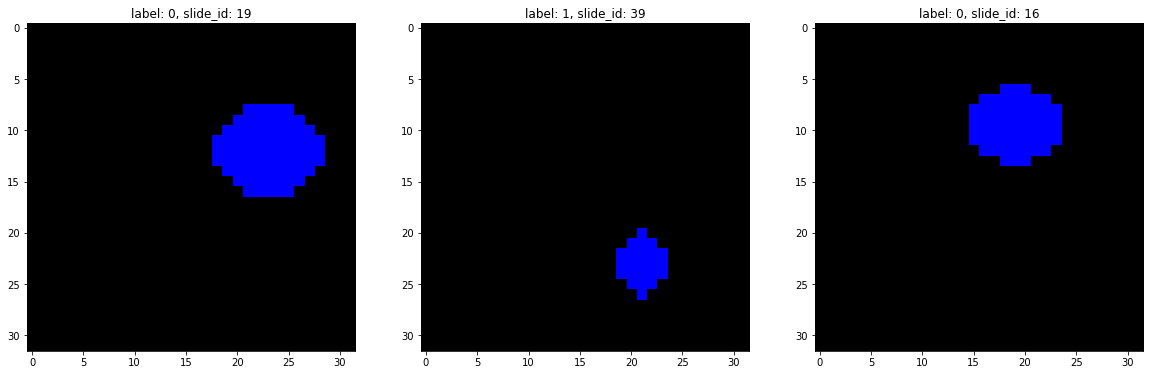

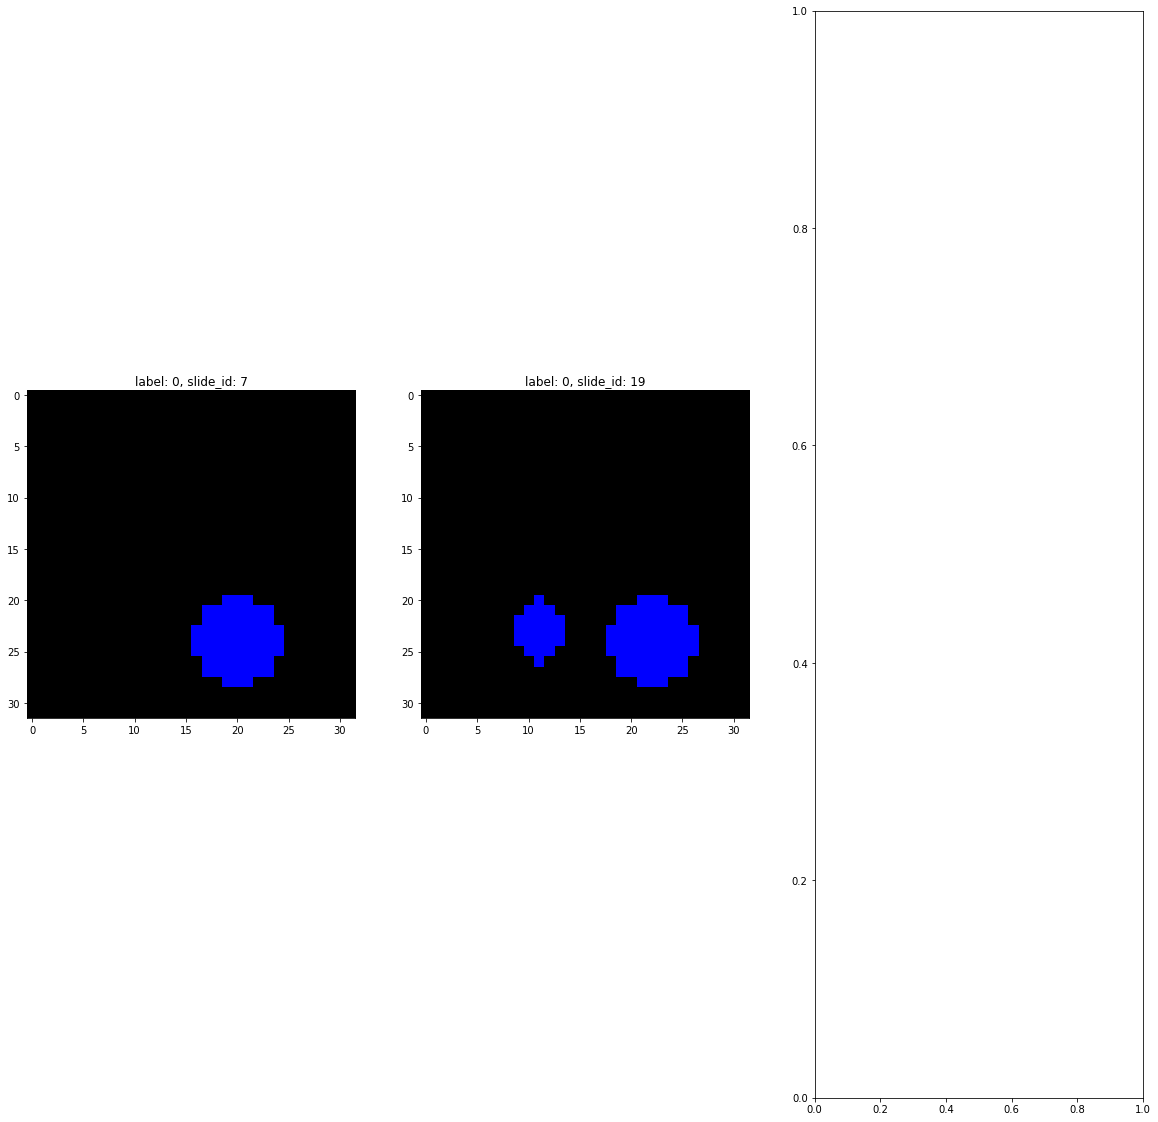

In [ ]:
print_bag(dataname, 'train', 64, figsize=(20,20),child_directory='')